### Initialize

In [1]:
# Define Program Version 
__ver__ = '01'

In [2]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import os.path
import pickle
import ipywidgets as widgets
from IPython.display import display
import ipywidgets

cst = tp.cst(sigmaf=0.5)
kHz = cst.h * 1e3
twopi = np.pi * 2
bec1db = bec1db_package.Tullia(delta=20)

The servers are not connected!
Using the local database copy. Could be outdated!


In [116]:
# Bunch of functions 

def lorentzian_fitfun(f, f0, gamma, amp=1, offset=0, gradient=0):
    return amp * (gamma/2)**2 / ((f-f0)**2 + (gamma/2)**2) + offset + gradient * f

def gaussian(x, x0, sigma, amp, offset=0): return offset + amp*np.exp(- (x-x0)**2 / (2*sigma**2))

def bin_data(xi, yi):
    x = np.unique(xi)
    y = [None] * x.size
    for i in range(x.size): y[i] = yi[xi == x[i]]
    # Return 
    y_mean = np.array([a.mean() for a in y])
    y_err = np.array([np.std(a) / (a.size**0.5) for a in y])
    return (x, y_mean, y_err, y, xi, yi)

# returns rabi in kHz
@np.vectorize
def volt2rabi(volt):
    if volt < 0.1 or volt > 5:
        return 0
    volt = np.log10(volt)
    dbm = 1.5863 +0.2211*volt -0.1022*volt**2 -0.1301*volt**3 -0.0862*volt**4 +0.2323*volt**5 +0.1624*volt**6 -0.1552*volt**7 -0.1206*volt**8
    dbm = 10**dbm
    sqrtpwr = (10**((dbm-30)/10))**(1/2)
    return -0.0332 +0.5832*sqrtpwr -0.0167*sqrtpwr**2

from scipy.optimize import brentq
# Provide rabi in kHz
@np.vectorize
def rabi2volt(rabi):
    if rabi <= volt2rabi(0.1) or rabi >= volt2rabi(5):
        print('outside valid range')
        return 0
    def funSolve(v):
        return rabi - volt2rabi(v)
    return brentq(funSolve, 0.1, 5)
def meshgrid(xLen=10, yLen=10, data=None):
    if data is not None: yLen, xLen = data.shape
    return np.meshgrid(np.arange(xLen, dtype=np.float), np.arange(yLen, dtype=np.float))
def gaussian_2d(x, y, cx=1, cy=1, sx=1, sy=1, amp=1, offset=0, angle=0):
    x, y = x - cx, y - cy
    sx, sy = 2*sx**2, 2*sy**2
    a = angle * np.pi / 180
    xp, yp = x*np.cos(a) + y*np.sin(a), - x*np.sin(a) + y*np.cos(a)
    return offset + amp * np.exp(-xp**2/sx - yp**2/sy)
    
def gaussian_2d_guess(data, x=None, y=None):
    if x is None: x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    t = np.sum(data)
    cx, cy = np.sum(data * x) / t, np.sum(data * y) / t
    sx, sy = (np.sum(data * (x-cx)**2) / t)**(1/2), (np.sum(data * (y-cy)**2) / t)**(1/2)
    return (cx, cy, sx, sy, data[int(cy), int(cx)], np.mean(data)/5, 0.0)
    
def fit_gaussian_2d(data, guess=None, plot=False):
    if guess is None: guess = gaussian_2d_guess(data)
    fr = tp.optimize.surface_fit(data, fun=gaussian_2d, guess=guess, show=plot)
    return fr
def gaussian_2d_integral(data, nsigma, fr=None, ideal=False, plot=False, guess=None, return_mask=False):
    if fr is None: fr = fit_gaussian_2d(data, guess=guess)
    # Generate the fitted data
    x, y = meshgrid(data=data)
    fit_data = gaussian_2d(x, y, *fr)
    amp = 1 if len(fr) <= 4 else fr[4]
    offset = 0 if len(fr) <= 5 else fr[5]
    # Ideal case
    if ideal:
        return np.sum(fit_data - offset)
    # Data case
    threshhold = np.exp(- nsigma**2/2) * amp + offset
    mask = fit_data >= threshhold
    # Plot
    if plot:
        plt.figure()
        plt.imshow(data)
        fit_data[~mask] = 0
        plt.imshow(mask, alpha=0.2, cmap='gray')
    
    # Mask return
    if return_mask:
        return mask
    
    return np.sum(data[mask])

''' 
Copy image names from clipboard and get parameters 
df : if you want to add on to the older df
init : initialize and return empty df
var : list of strings (variable names) that you want to retrive from database
x_var : a string (variable name), available as df.x
image_func : either tp.Image or tp.Hybrid_Image
using : 0=TopA only, 1=TopB only, 2=All Images
'''
def get_from_clipboard(df=None, init=False, var=None, x_var=None, image_func=tp.Image, using=2, display=False):
    # If initializing, then return empty dataframe
    if init: return pd.DataFrame(columns=['name','image'])
    
    # If df is None, make an empty one
    if df is None: 
        df = pd.DataFrame(columns=['name','image'])
    
    # Get the copied image names
    pasted = pd.read_clipboard(header=None, names=['name'])['name'].tolist()
    
    # Filter for using 0:TopA only, 1:TopB only, 2:all
    if using==0:
        pasted_filtered = [p for p in pasted if p[-1]=='A']
    elif using==1:
        pasted_filtered = [p for p in pasted if p[-1]=='B']
    else:
        pasted_filtered = [p for p in pasted]
    
    # Add it to df if not already in there
    names = df.name.tolist()
    for n in tqdm(pasted_filtered, desc='Loading'):
        if n not in names:
            df.loc[df.shape[0]] = n
            df.image[df.shape[0]-1] = image_func(name=n)
    
    # sort in time
    df.sort_values('name', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Get Parameters
    try: bec1db.refresh()
    except: pass
    df['shot'] = np.linspace(0,df.shape[0]/2-0.5,df.shape[0])
    if x_var is not None:
        df['x'] = bec1db.image_query(df.name.tolist(), [x_var])[x_var]
    if type(var) is str:
        df[var] = bec1db.image_query(df.name.tolist(), [var])[var]
    elif type(var) is list:
        _ = bec1db.image_query(df.name.tolist(), var)
        for n in var:
            df[n] = _[n]
    
    # Print Information
    if display:
        print('Pasted Sample : ', pasted[0:2])  
        print('Newly added images       : {}'.format(df.shape[0]- len(names)))
        print('Total number of images   : {}'.format(df.shape[0]))
    
    # return
    return df


def get_roi(data, center=[0,0], width=100, height=100):
    center = (data.shape[1]//2 + center[0], data.shape[0]//2 + center[1])
    return tp.imagedata.get_cropi(data, center=center, width=width, height=height)

def atom_num_filter(df_, keep = 0.15, offset = 0.0, plot=True):
    # Prepare
    if plot: fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    if plot: ax[0].plot(df_['shot'], df_['total_atoms']/1e6,'.-', label='All')
    shapes = [df_.shape]
    
    # Filter
    median_numbers = np.median(df_.total_atoms)
    offset += 1
    using = (df_.total_atoms.values > median_numbers*(offset-keep)) & (df_.total_atoms.values <= median_numbers*(offset+keep))
    bad = df_[~using] 
    df_ = df_[using]
    df_.reset_index(inplace=True, drop=True)
    shapes.append(df_.shape)
    if plot: ax[0].plot(bad['shot'], bad['total_atoms']/1e6, 'rx', label='Atom Num Filter')
    if plot: ax[0].axhline(median_numbers/1e6, linestyle='--', color='k', alpha=0.5)

    if plot: 
        # Plot
        median_numbers = np.median(df_.total_atoms)
        ax[1].plot(df_['shot'], df_['total_atoms']/median_numbers,'o-')
        ax[1].axhline(1, linestyle='--', color='k', alpha=0.5)

        ax[0].legend()
        ax[0].set(title = 'Atom number stability', xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [M]')
        ax[1].set(title = 'Median Atom Num {:.2f} M'.format(median_numbers/1e6), xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [median]')
        plt.tight_layout()

        # Relevant Information
        print('''
        Total Loaded Images {}
        Atom Num Filter     {}
        Removed Images      {}
        '''.format(shapes[0][0], shapes[1][0], shapes[0][0]-shapes[1][0]))
    
    return using

def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))

def mesh_for_2d_plot(x, y, z):
    x1 = np.concatenate([ [2*x[0] - x[1]], x])
    x2 = np.concatenate([x, [2*x[-1] - x[-2]]])
    x = np.mean([x1, x2], axis=0)

    y1 = np.concatenate([ [2*y[0] - y[1]], y])
    y2 = np.concatenate([y, [2*y[-1] - y[-2]]])
    y = np.mean([y1, y2], axis=0)
    
    return (x, y, z)

def fourier_transform(curve, k):
    return np.array([np.trapz(curve.y * np.exp(-1j * ki * curve.x) , curve.x) for ki in k])
'''
Least square curve fitting to {x,y} data 
========================================
Inputs Required : 
    fitfun - python function with inputs (of type x_data, p0, p1, p2, p3, ...) and returns np.array y_data 
    guess  - could be a simple list, or more detailed dict (see below for more info) 
    x_data - I think this could be anything supported by fitfun input, to be safe, keep it np.array 
    y_data - must be np.array 
    
Inputs Optional : 
    y_err - sigma for the y_data, defaults to np.ones_like(y_data). The following is optimized sum ( (y_data-fitfun(...))/y_err )^2
    fixed - dict(gradient = 0, tau = 5, ...) : parameters to fix. NOTE: if guess contains the same key, that key will not be fixed 
    plot  - True / False : Plots a standard figure with data, fit line, residuals 
    info  - True / False : prints fit results 

guess : recommended the third option 
    1) guess = [12, 3, -np.pi, ...] : a simple list 
    2) guess = [ [12, (10, 14), 'meter'], 3, [np.pi, (0, 2*np.pi)], ...] : mixture of simple value and fancy list 
    A fancy list for a guess contains up to three items -- the guess value itself, a tuple for lower and upper bounds, a string for units
    A fancy list must contain the guess itself, but the other two things are optional 
    3) guess = dict(tau = 12, phase = [np.pi, (0, 2*np.pi), 'radians'], ...) : a dictionary containing mixture of simple value and fancy list 

MUST DO : 
    - Make sure x_data, y_data, and y_err is valid for fitfun input/output and DOES NOT contain inf or nan. 

Properties : 
    fitresults : pandas dataframe of the fitresults 
    fitvalues : dict of fit values with parameters as keys, including the fixed and default parameters
    fiterrors : dict of fit errors with parameters as keys, including the fixed and default parameters
    fv : list of fit values, including the fixed and default parameters
    fe : list of fit errors, including the fixed and default parameters
    xp : finely spaced grid for same x range : np.linspace(self.x.min(), self.x.max(), 1000)
    
Special Methods : 
    __call__ : returns fitted curve at optionally provided x and overridden parameters : self(), self(x, phase=0, amp=0, ...), self(self.xp), 
    __len__ : len(self) returns the number of parameters the fitfun takes 
    __getitem__ : self['amp'] or self[1] : returns the fir value for given key or index 
    __setitem__ : self['amp'] = 0 or self[1] = 0 : fixes the 
    __bool__ : if self: or bool(self) : true if the fit was successful 
    __repr__ or __str__ : str(self) or print(self) : returns the fitresults in printable format 

Methods : 
    plot()
        two plots, data and fit curve on top, and residuals below. Optional inputs 
        ax : to plot somewhere specific
        fiterrors = False : include fit error band along with optimal fit 
        using = [] : which parameters to sue to calculate fiterrors band 
        divider = 0.25 : how to split the axes for residuals 
    plot_fitdata(ax=None) : data and fit curve 
    plot_residuals(ax=None) : residuals 
    plot_residuals_hist(ax=None, orientation='vertical) : histogram of the residuals 
    plot_fiterrors(ax=None, using=[]) : fit error band, optinally include only keys in using 
'''
import scipy.optimize

class Curve_Fit: 
    def __init__(self, fitfun, guess, x_data, y_data, y_err=None, fixed=dict(), plot=False, info=False): 
        ### Verify inputs 
        if not callable(fitfun): print("provided fitfun is not valid python function!")
        
        ### Process single item from guess -- return guess value, bounds, units 
        def temp_process_guess_item(item):
            units, bounds = None, [-np.inf, np.inf] # default value
            if type(item) in [list, tuple, np.ndarray]:
                value = item[0]
                if len(item) > 3: return [value, bounds, units]
                for i in item[1:]:
                    if type(i) is str: units = i
                    elif type(i) in [list, tuple, np.ndarray]: bounds = i
            else: value = item
            return [value, bounds, units]
        
        ### Process guess -- generate guess_keys, guess_values, guess_bounds, guess_units 
        # the order of keys will be determined by the order of fitfun input order 
        if type(guess) == dict:
            guess_keys = [k for k in fitfun.__code__.co_varnames[1:] if k in list(guess.keys())]
            temp_ = [temp_process_guess_item(guess[k]) for k in guess_keys]
        elif type(guess) in [list, tuple, np.ndarray]:
            guess_keys = fitfun.__code__.co_varnames[1:1+len(guess)]
            temp_ = [temp_process_guess_item(i) for i in guess]
        elif (type(guess) in [float, int]) or (np.issubdtype(guess, np.number)):
            guess_keys = fitfun.__code__.co_varnames[1:2]
            temp_ = [temp_process_guess_item(guess)]
        else:
            print('Does NOT understand data type of guess : ', guess)
        guess_values, guess_bounds, guess_units = np.array([i[0] for i in temp_]), np.array([i[1] for i in temp_]).T, [i[2] for i in temp_]
        
        ### Extract all fixed items, including provided and default ones
        fixed_func_defaults = {k:v for k, v in zip(fitfun.__code__.co_varnames[-len(fitfun.__defaults__):], fitfun.__defaults__)}
        fixed_dict = {**fixed_func_defaults, **fixed}
        for k in guess_keys: fixed_dict.pop(k, None)
        
        ### Define temp fitfun for internal use only 
        def fitfun_args(x, *args):
            return fitfun(x, **{k: v for k, v in zip(guess_keys, args)}, **fixed_dict)
        
        ### Fit Data 
        success = False
        try:
            fv_, fe_ = scipy.optimize.curve_fit(fitfun_args, x_data, y_data, guess_values, sigma=y_err, bounds=guess_bounds)
            fe_ = np.sqrt(np.diag(fe_))
            success = True
        except (ValueError, RuntimeError) as err: 
            fv_, fe_ = guess_values, guess_values*np.nan
            print("CAN'T FIT, Returning Original Guess: Details of Error :: {}".format(err))
            
        ### Formatting Fit Results 
        fitresults_dict = dict(FitValue=fv_, FitError=fe_, Units=guess_units, Guess=guess_values, LowerBound=guess_bounds[0], UpperBound=guess_bounds[1])
        fitresults_df = pd.DataFrame(fitresults_dict, index=guess_keys, columns=['FitValue','FitError','Units','Guess','LowerBound','UpperBound'])
        for k, v in fixed_dict.items(): fitresults_df.loc[k] = [v, 0, None, v, v, v]
        fitresults_df = fitresults_df.loc[fitfun.__code__.co_varnames[1:], :] # sort the index by function input list 
        fitresults_df['FitError%'] = np.nan_to_num(np.abs(fitresults_df['FitError'] / fitresults_df['FitValue'])) * 100
        
        ### Store results to self
        self.fitresults = fitresults_df
        self.fitfun = fitfun
        self.success = success
        self.x = x_data
        self.y = y_data
        self.y_err = y_err
        
        ### Plots and display 
        if plot: self.plot()
        if info: print(self)
    
    @property
    def fitvalues(self): return dict(self.fitresults['FitValue'])
    @property
    def fiterrors(self): return dict(self.fitresults['FitError'])
    @property
    def fv(self): return self.fitresults['FitValue'].values
    @property
    def fe(self): return self.fitresults['FitError'].values
    @property
    def xp(self): return np.linspace(self.x.min(), self.x.max(), 1000)
    
    def __call__(self, *args, **kwargs): 
        x = args[0] if len(args) == 1 else self.x
        return self.fitfun(x, **{**self.fitvalues, **kwargs})
    def __len__(self): return len(self.fv)
    def __getitem__(self, key): 
        if (type(key) in [int, float]): return self.fv[int(key)]
        elif type(key) == str: return self.fitvalues.get(key, None)
    def __setitem__(self, key, value): 
        if type(key) in [int, float]: key = self.fitresults.index.values[int(key)]
        r = self.fitresults.loc[key].values
        r[0], r[1], r[6] = value, 0, 0
        self.fitresults.loc[key] = r
    def __bool__(self): return self.success
    def __repr__(self): return self.fitresults.to_string()
    def __str__(self): return self.fitresults.to_string()
    
    def plot_fitdata(self, ax=None):
        if ax is None: fig, ax = plt.subplots()
        ax.errorbar(self.x, self.y, self.y_err, fmt='r.')
        ax.plot(self.xp, self(self.xp), 'k')
        return ax
    def plot_residuals(self, ax=None):
        if ax is None: fig, ax = plt.subplots()
        ax.axhline(0, c='k', alpha=0.5)
        ax.vlines(self.x, self.x*0, self.y-self())
        ax.plot(self.x, self.y-self(), 'r.')
        return ax
    def plot_residuals_hist(self, ax=None, orientation='vertical'):
        if ax is None: fig, ax = plt.subplots()
        ax.hist(self.y-self(), orientation=orientation)
        return ax
    def plot_fiterrors(self, ax=None, using=[]):
        ax = self.plot_fitdata(ax)
        xp = self.xp
        if type(using) == str: using = [using,]
        if len(using) == 0: using = self.fitresults.index.values
        ys = [self(xp)]
        for k in using:
            ys.append(self(xp, **{k : self.fitvalues[k] - self.fiterrors[k]}))
            ys.append(self(xp, **{k : self.fitvalues[k] + self.fiterrors[k]}))
        ax.fill_between(xp, np.min(ys, axis=0), np.max(ys, axis=0), color='g', alpha=0.25)
        return ax
    def plot(self, ax=None, fiterrors=False, using=[], divider=0.25):
        if ax is None: ax = plt.subplots(figsize=[5,5])[1]
        (ax1, ax2) = divide_axes(ax, divider=divider, direction='vertical', shared=True)
        if fiterrors: self.plot_fiterrors(ax1, using=using)
        else: self.plot_fitdata(ax1)
        self.plot_residuals(ax2)
        return (ax1, ax2)

# Additional Functions useful for general matplotlib axes creation 
'''
Adds a subplot inside a given axes 
==================================
Inputs -- all dimensions are in fractional sizes relative to the axes 
    ax : main axes 
    origin : location of the left bottom corner for the added subplot  
    width, height : width and height of the subplot 

Inputs Optional 
    bg = 'w' : the color for the background of the subplot, can't be transparent, because needs to cover the background 
    remove = False : remove the x,y-axis information from the parent axes 

Returns axes object of the subplot 
'''
def add_subplot_axes(ax, origin=[0.5,0.25], width=0.5, height=0.3, bg='w', remove=False):
    fig = ax.figure
    inax_position  = ax.transAxes.transform(origin)
    x, y = fig.transFigure.inverted().transform(inax_position)
    subax = fig.add_axes([x,y,ax.get_position().width*width,ax.get_position().height*height],facecolor=bg)
    if remove: ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    return subax


'''
Divide an axes into two, horizontally or vertically 
===================================================
Inputs :
    ax : main axes 
    divider = 0.3 : fractional size for the bottom subplot 
    direction = 'vertical' : or 'horizontal' for division of the axes 
    shared = True : share the same x or y axis 

Returns (ax1, ax2) two subplot axes objects 
'''
def divide_axes(ax, divider=0.3, direction='vertical', shared=True):
    # Fractional Dimension for new axes  ; [origin_x, origin_y, width, height]
    if direction == 'horizontal':
        dim1 = [divider, 0, 1-divider, 1]
        dim2 = [0, 0, divider, 1]
    else:
        dim1 = [0, divider, 1, 1-divider]
        dim2 = [0, 0, 1, divider]
    # Add axes 
    ax1 = add_subplot_axes(ax, origin=dim1[0:2], width=dim1[2], height=dim1[3], bg='w', )
    ax2 = add_subplot_axes(ax, origin=dim2[0:2], width=dim2[2], height=dim2[3], bg='w', remove=True)
    # Adjust ticks for top (right) axes
    if direction == 'horizontal':
        ax1.tick_params(axis='y', which='both', direction='in', labelbottom=False, right=True)
        ax2.tick_params(axis='y', which='both', direction='in', right=True)
        if shared: ax1.get_shared_y_axes().join(ax1, ax2)
    else:
        ax1.tick_params(axis='x', which='both', direction='in', labelbottom=False, top=True)
        ax2.tick_params(axis='x', which='both', direction='in', top=True)
        if shared: ax1.get_shared_x_axes().join(ax1, ax2)
    # return
    return (ax1, ax2)

In [4]:
# Useful snippets 

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=1000, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )



In [5]:
# Fermi Gas Classes 

# Import statements and useful functions 
import numpy as np
import pandas as pd
import therpy as tp
import scipy.optimize
import scipy.interpolate
import os.path
import os
import urllib.request

###### Parameters
cst_FG = tp.cst()
cst_FG.c1 = ((cst_FG.twopi * cst_FG.hbar**2)/(cst_FG.mass))**(1/2)
cst_FG.c2 = 1.0/(6*cst_FG.pi**2) * (2*cst_FG.mass/cst_FG.hbar**2)**(3/2)
cst_FG.virial_coef = [1.0, 3.0*2**(1/2)/8, -0.29095295, 0.065]
cst_FG.Critical_Temperature_TF = 0.17
cst_FG.xi = 0.37
cst_FG.xi_n = 0.45
def thermal_wavelength(kT):
    return cst_FG.c1 / (kT)**(1/2)
###### Ideal Gas
@np.vectorize
def density_ideal(kT, mu):
    if kT == 0:
        if mu <= 0:
            print('Density is undefined for negative mu and zero temperature')
            return 0.0
        return cst_FG.c2 * (mu)**(3/2)
    return thermal_wavelength(kT)**(-3) * tp.FermiFunction(m=3/2, logz=mu/kT)
@np.vectorize
def pressure_ideal(kT, mu):
    if kT == 0:
        return 2/5*density_ideal(0, mu)*mu
    return kT/thermal_wavelength(kT)**3 * tp.FermiFunction(m=5/2, logz=mu/kT)
@np.vectorize
def TTF_to_betamu_ideal(TTF, a=-10000, b=100):
    if TTF <= 0.01: return 1/TTF # Zero T approximation
    def minimizer(mu): return TTF - (cst_FG.h / cst_FG.n2EF(density_ideal(cst_FG.h, mu*cst_FG.h))) # Fix kT to 1 Hz and find mu in Hz (=betamu)
    return scipy.optimize.brentq(minimizer, a, b)   
@np.vectorize
def entropy_NkB_ideal(kT, mu):
    if kT == 0: return 0.0
    return (5/2 * tp.FermiFunction(m=5/2, logz=mu/kT) / tp.FermiFunction(m=3/2, logz=mu/kT)) - mu/kT
@np.vectorize
def entropy_NkB_TTF_ideal(TTF):
    if TTF == 0: return 0.0
    return entropy_NkB_ideal(cst_FG.h, TTF_to_betamu_ideal(TTF) * cst_FG.h)
###### Virial Gas
@np.vectorize
def density_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*1/kT*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*2/kT*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*3/kT*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*4/kT*np.exp(4*mu/kT) )
@np.vectorize
def pressure_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*np.exp(4*mu/kT) )

# Ideal Fermi Gas definition 
'''
Ideal Fermi Gas
    - functions to relate various Thermodynamic quantities

Methods
    - thermal_wavelength
    - density
    - pressure
    - TTF_to_betamu
    - entropy_NkB
    - entropy_NkB_TTF

Dataframe contains links between. Note that E = 3/2 PV
    - T/T_F
    - mu/E_F
    - P/P0 = E/E0
    - k/k0
    - Cv/Nk
    - S/Nk
'''
class Ideal_Fermi_Gas:
    def __init__(self, pts=1000, TTF_max = 200, TTF_min=0.05):
        # Define dataframe for fast computation
        kT = 1 * cst_FG.h
        mu = np.concatenate([np.linspace(self.TTF_to_betamu(TTF_max), 5, pts//10*9)[:-1], np.linspace(5, self.TTF_to_betamu(TTF_min), pts//10)]) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = self.pressure(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_ideal = pd.DataFrame(data=dict(betamu=mu/kT))
        df_ideal['T/T_F'] = kT / EF
        df_ideal['mu/E_F'] = mu / EF
        df_ideal['P/P0'] = P / P0
        df_ideal['k/k0'] = c1.diff(method='central2').y
        df_ideal['Cv/Nk'] = 3/2 * 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - 1/df_ideal['k/k0'])
        df_ideal['S/Nk'] = 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - df_ideal['mu/E_F'])
        self.df = df_ideal
    
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_ideal(kT, mu)
    def pressure(self, kT, mu): return pressure_ideal(kT, mu)
    def TTF_to_betamu(self, TTF, a=-10000, b=100): return TTF_to_betamu_ideal(TTF, a, b)
    def entropy_NkB(self, kT, mu): return entropy_NkB_ideal(kT, mu)
    def entropy_NkB_TTF(self, TTF): return entropy_NkB_TTF_ideal(TTF)

# Virial Fermi Gas Definition 
'''
Fermi Gas, Virial Expansion
'''
class Virial_Fermi_Gas:
    def __init__(self, TTF_max = 200, TTF_min=0.5):
        # Generate dataframe
        kT = 1 * cst_FG.h
        mu = np.linspace(TTF_to_betamu_ideal(TTF_max), TTF_to_betamu_ideal(TTF_min), 10000) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = pressure_ideal(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_virial = pd.DataFrame(data=dict(betamu=mu/kT))
        df_virial['T/T_F'] = kT / EF
        df_virial['mu/E_F'] = mu / EF
        df_virial['P/P0'] = P / P0
        df_virial['k/k0'] = c1.diff(method='central2').y
        df_virial['Cv/Nk'] = 3/2 * 1/df_virial['T/T_F'] * (df_virial['P/P0'] - 1/df_virial['k/k0'])
        self.df = df_virial
        
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_virial(kT, mu)
    def pressure(self, kT, mu): return pressure_virial(kT, mu)
    

# Unitary Fermi Gas using Mark's EoS 
'''
Mark's equation of state
'''
class Unitary_Fermi_Gas: 
    def __init__(self,):
        # Download the data if not already
        p_ = tp.getpath('Projects','Data','EoS','UnitaryFermiGasExperiment_kPEoS.csv')
        if not os.path.isfile(p_):
            print("Downloading Database -- Might take some time!")
            url = 'https://www.dropbox.com/s/8irmfrn2zdvfgba/UnitaryFermiGasExperiment_kPEoS.csv?dl=1'
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            # Create folder
            os.makedirs(os.path.split(p_)[0], exist_ok=True)
            with open(p_, "wb") as f :
                f.write(data)
        
        # Load Data
        self.df = pd.read_csv(p_)
        
        # Interpolated Density Data
        x = np.array(self.df['T/T_F'])
        y = np.array(self.df['mu/E_F'])
        VFG = Virial_Fermi_Gas()
        c = tp.Curve(x = np.array(VFG.df['T/T_F']), y = np.array(VFG.df['mu/E_F'])).sortbyx().trim(xlim=[np.max(x),np.max(x)+0.1])
        muEF_curve = tp.Curve(x = np.concatenate([[0], x, c.x]), y = np.concatenate([[cst_FG.xi], y, c.y]))
        TTF = np.linspace(0, muEF_curve.maxx, 10000)
        muEF = muEF_curve(TTF)
        c_muEF_extension = tp.Curve(TTF, muEF)
        density_c_low = scipy.interpolate.interp1d(x = TTF / muEF, y = muEF)
        density_c_high = scipy.interpolate.interp1d(x = muEF[1:] / TTF[1:], y = muEF[1:])
        self.density_c_low = density_c_low
        self.density_c_high = density_c_high
        self.density = np.vectorize(self.density_single)
        
        # Interpolated Energy Data
        IFG = Ideal_Fermi_Gas()
        c1 = tp.Curve(np.array(self.df['T/T_F']), np.array(self.df['E/E0'])) # Mark EoS E/E0 vs T/T_F
        c2 = tp.Curve(np.array(IFG.df['T/T_F']), np.array(IFG.df['P/P0'])).trim(xlim=[c1.maxx + 0.2, np.inf]) # Ideal Fermi Gas E/E0 = P/P0 vs T/T_F, from end of Mark EoS to end with some padding for smooth transition
        energy_c = scipy.interpolate.interp1d(x = np.concatenate([[0], c1.x, c2.x]), y = np.concatenate([[cst_FG.xi], c1.y, c2.y+(cst_FG.xi_n-1)]))
        self.energy_c = energy_c
        self.IFG = IFG
        self.E_E0 = np.vectorize(self.E_E0_single)
        
    # Various functions
    def density_single(self, kT, mu):
        # Zero T
        if kT == 0:
            return cst_FG.EF2n(mu/cst_FG.xi, neg=True)
        if mu/kT > 4:
            return cst_FG.EF2n(mu / self.density_c_low(kT/mu), neg=True)
        if mu/kT > -0.5:
            return cst_FG.EF2n(mu / self.density_c_high(mu/kT), neg=True)
        return density_virial(kT, mu)
    
    def density_hybrid(self, z, kT, mu, trapf=23.9):
        return self.density(kT, mu - 1/2 * cst_FG.mass * (2*np.pi*trapf)**2 * z**2)
    
    def E_E0_single(self, TTF):
        if TTF < self.energy_c.x.max():
            return self.energy_c(TTF)
        else:
            # Compute using IFG
            # betamu = self.IFG.TTF_to_betamu(TTF)
            # return (self.IFG.pressure(cst_FG.h, betamu * cst_FG.h) / self.IFG.pressure(0, betamu * cst_FG.h)) + (cst_FG.xi_n-1)
            return self.energy_c.y[-1]

# Make objects
IFG = Ideal_Fermi_Gas()
VFG = Virial_Fermi_Gas()
UFG = Unitary_Fermi_Gas()

# Special Functions
def hybrid_E_N(kT, mu, trapf=23.35, simple=True, nz = None):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    if nz is None:
        n_0 = UFG.density(kT, mu)
        z_max = 0
        while True:
            z_max += 50e-6
            if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
        z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
        n = UFG.density(kT, mu - u_* z**2)
    else:
        z = nz.x
        n = nz.y
        
    if simple: # If simple, then simply return 4 * <U>
        return 4 * np.trapz(u_*z**2 * n, z) / np.trapz(n, z)
    
    # Compute total E_int + U energy
    EF = cst_FG.n2EF(n)
    TTF = kT / EF
    E_N_z = UFG.E_E0(TTF) * 3/5 * EF
    E_N = (np.trapz(E_N_z * n, z) + np.trapz(u_*z**2 * n, z)) / np.trapz(n, z)
    return E_N

# Special Functions
def hybrid_total_atoms(kT, mu, trapf=23.35, cross_section=np.pi*(58e-6)**2):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    n_0 = UFG.density(kT, mu)
    z_max = 0
    while True:
        z_max += 50e-6
        if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
    z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
    n = UFG.density(kT, mu - u_* z**2)
    N = np.trapz(n, z) * cross_section
    return N

In [106]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

# In Situ Density Modulation

In [6]:
# Some Fitting functions 
import scipy.special
def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x

In [7]:
# Desplay widgets to select various parameters 

# All the variables to load 
var = ['ExpansionTime','SideGreenEvap','WaitBox',
       'IREvap','HeatTime','ShakeTime','ShakeWait', 'HeatCycles',
       'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
       'SeqMode']

fontsize = 15

# Saving and Loading widgets 
WID_SaveAnalyzedDataBtn = widgets.Button( description='Save Data', button_style='success', )
WID_Folder = widgets.Text( value='AnalyzedData', placeholder='Type Folder to store data', description='Save Folder :')
WID_DatasetType = widgets.Text( value='InsituShakingVsFreq', placeholder='Type Dataset Type/Information', description='Dataset Type :',)
WID_DatasetDate = widgets.Text( value='06_22_2017', placeholder='Type Dataset Date, E.x. 06_15_2017', description='Dataset Date :',)
WID_DatasetName = widgets.Text( value='DS3', placeholder='Type Dataset Name, E.x. DS1', description='Dataset Name :',)

# Select a Particular x_variable
WID_x_var = widgets.ToggleButtons(description='x variable = = > ', 
            options=['ShakeWait', 'ShakingCycles', 'BoxShakeFreq', 'BoxShakeAmp', 'HeatCycles'])
display(WID_x_var)

# Select a Particular x_variable
WID_using_image = widgets.ToggleButtons(description='Image Selection = = > ', 
            options=['A', 'B', 'Both'])
display(WID_using_image)

# Select a Particular X_Label for the plots 
WID_xlabel = widgets.ToggleButtons(description='xlabel for plots = > ', 
            options=['Waittime (ms)', 'Shaking Cycles', 'Shaking Frequency (Hz)', 'Shaking Amplitude (Cicero Volts)', 'Heating Cycles'])
display(WID_xlabel)

# Reduced Plots and Info for Faster Processing 
WID_info = widgets.Checkbox( value=True, description='Show all info plots',)
display(WID_info)

# Additional WID used later 
WID_atoms_keep = widgets.FloatSlider(value=0.07, min=0.01, max=0.4, step=0.01,
                description='Atom Num Selection:', readout=True, readout_format='.2f',
                layout=widgets.Layout(width='50%'), )

WID_height = widgets.IntSlider(value=181, min=105, max=219, step=2,
             description='Height:', readout=True, layout=widgets.Layout(width='50%'), )

WID_width = widgets.IntSlider(value=75, min=15, max=177, step=2,
             description='Width:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_x = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center X:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_y = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center Y:', readout=True, layout=widgets.Layout(width='50%'), )

WID_clim_dN = widgets.FloatSlider(value=0.15, min=0.01, max=0.50, step=0.001,
                description='clim for dN:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

WID_clim_dN_N = widgets.FloatSlider(value=0.15, min=0.01, max=0.5, step=0.001,
                description='clim for dN/N:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

In [38]:
# ONLY ONCE -- Initialize empty dataframe and select options 
df_all = get_from_clipboard(init=True)

## Load Data from Images

In [39]:
# Import from Clipboard 
x_var = WID_x_var.value
using = 0 if WID_using_image.value == 'A' else 1 if WID_using_image.value == 'B' else 2
info = WID_info.value
df_all = get_from_clipboard(df=df_all, init=False, var=var, x_var=x_var, image_func=tp.Hybrid_Image, using=using, display=info)

if WID_info.value:
    df_all.head(5) 


Pasted Sample :  ['07-11-2017_21_59_32_TopA', '07-11-2017_21_59_32_TopB']
Newly added images       : 180
Total number of images   : 180


07-11-2017_18_42_33_TopA
120.0


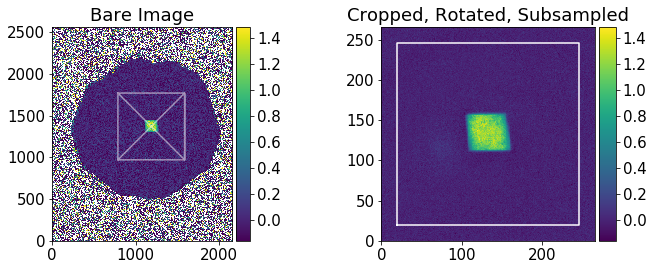

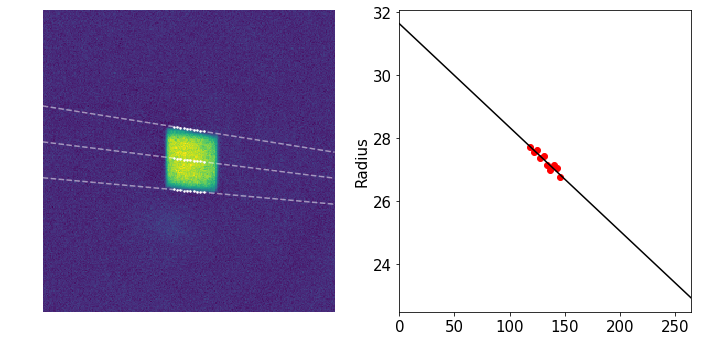

In [128]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1187, center_y = 1370, width=800, height=800, fudge=1.75, subsample=3, 
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.0, radial_selection=0.8,)}

# Apply settings
for i, r in df_all.iterrows():
    r.image.set(**settings)
    
# Tests
if WID_info.value: 
    test = 0
    print(df_all.image.iloc[test].name)
    df_all.image.iloc[test].plot_crop()
    print(df_all.x.iloc[test])
    plt.show()
    fig, ax = plt.subplots(ncols=2, figsize=[10, 5])
    df_all.image.iloc[test].xsec.infoplot(axs=ax)
    plt.tight_layout()

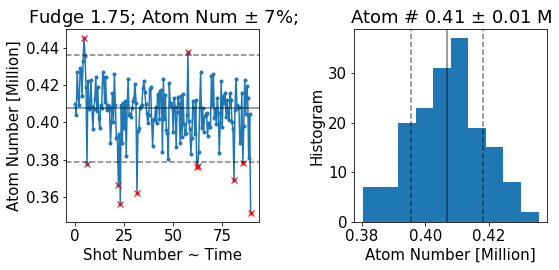

In [129]:
# Atom Number Filter 

# Parameters 
display(WID_atoms_keep)
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image, desc='Atoms')]
using = atom_num_filter(df_all, keep=WID_atoms_keep.value, offset=0.0, plot=False)
df = df_all[using]

def makeplot_atomnum_time(ax, df_all=df_all, using=using):
    ax.plot(df_all.shot, df_all.total_atoms/1e6, 'C0.-', 
            df_all[~using].shot, df_all[~using].total_atoms/1e6, 'rx')
    median_atom_num = np.median(df_all.total_atoms) / 1e6
    ax.axhline(median_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.axhline(median_atom_num * (1 + WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax.axhline(median_atom_num * (1 - WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax.set(xlabel='Shot Number ~ Time', ylabel='Atom Number [Million]', 
              title='Fudge {}; Atom Num $\pm$ {:.0f}%;'.format(df.image.iloc[0].fudge, WID_atoms_keep.value*100))

def makeplot_atomnum_hist(ax, df=df):
    ax.hist(df.total_atoms/1e6)
    mean_atom_num = np.mean(df.total_atoms)/1e6
    std_atom_num = np.std(df.total_atoms)/1e6
    ax.axvline(mean_atom_num, linestyle='-', c='k', alpha=0.5)
    ax.axvline(mean_atom_num + std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.axvline(mean_atom_num - std_atom_num, linestyle='--', c='k', alpha=0.5)
    ax.set(xlabel='Atom Number [Million]', ylabel='Histogram', title='Atom # {:.2f} $\pm$ {:.2f} M'.format(mean_atom_num, std_atom_num))

fig, ax = plt.subplots(ncols=2, figsize=[8, 4])
makeplot_atomnum_time(ax[0], df_all, using)
makeplot_atomnum_hist(ax[1], df)
plt.tight_layout()

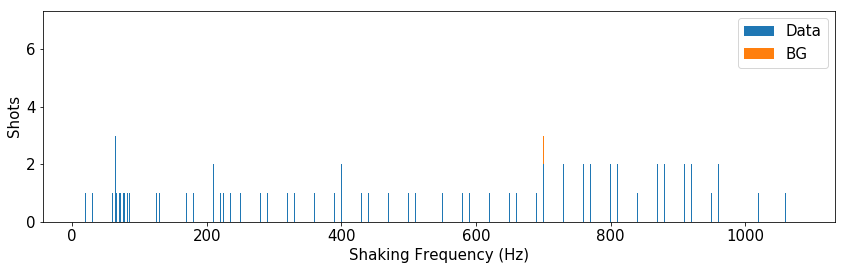

In [130]:
# Dataset Explorer 
bg_variable = 'ShakingCycles'
bg_value = 0

# Count number of images 
unique_x = np.unique(df.x)
data_counts = np.array([np.sum(df.x[df[bg_variable] != bg_value].values == x) for x in unique_x])
bg_counts = np.array([np.sum(df.x[df[bg_variable] == bg_value].values == x) for x in unique_x])
dataset_counter = [unique_x, data_counts, bg_counts]

# Plot counter 
def makeplot_dataset_counter_barchart(ax, count = dataset_counter):
    if len(count[0]) > 1: width = np.min(np.diff(count[0]))/1.5
    else: width = 1
    ax.bar(count[0], count[1], width, label='Data')
    ax.bar(count[0], count[2], width, bottom=count[1], label='BG')
    ax.legend()
    ax.set(xlabel = WID_xlabel.value, ylabel='Shots')
    
fig, ax = plt.subplots(figsize=[12, 4])
makeplot_dataset_counter_barchart(ax)
plt.tight_layout()

In [131]:
np.sum(dataset_counter[2])

15

In [132]:
# SAME BG : Compute df_data : delta_rho and delta_rho_rho for datasets with both bg and data images with some threshold 
# Correcting z ONLY for BG and not data because this is double sided shaking

# inputs 
threshold_image_num = 1

# n(z) 
df['nz_raw'] = [im.nz for im in tqdm(df.image, desc='n(z)')]

# Fitting erf to get center and box length 
guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x
df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

# Get the background profile 
bg_ind = (df[bg_variable] == bg_value)
length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
amp = np.mean([fr[4] for fr in df.fitres_erf])
nz_bg_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
    (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

# Process particular x 
def process_particular_x(x, ):
    # collect bg and data ind for this x 
    data_ind = (df[bg_variable] != bg_value) & (df.x == x)
    
    # compute parameters 
    freq = np.unique(df.BoxShakeFreq[data_ind])[0]
    cycles = np.unique(df.ShakingCycles[data_ind])[0]
    
    # Get all nz
    nz_data_all = [tp.Curve(nz_bg.x, 
             (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]
    
    # Average nz 
    nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
    nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])
    
    # compute delta rho 
    x = nz_bg.x.copy()
    delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
    delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )
    
    # return 
    return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
            nz_bg_all, length, amp, np.sum(data_ind), 
            np.sum(bg_ind), freq, cycles)
    

# df_data 
df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                'nz bg', 'nz data all', 'nz bg all', 'length', 
                                'amp', '# data', '# bg', 'freq', 'cycles'])
for i, x in enumerate(dataset_counter[0]):
    if (dataset_counter[1][i] >= threshold_image_num):
        df_data.loc[x] = process_particular_x(x)
        

In [133]:
# x - variables 
print(df_data.index.values)

[   10.    20.    30.    40.    50.    60.    62.    64.    66.    68.
    70.    72.    74.    76.    78.    80.    82.    84.    85.    90.
   120.   125.   130.   135.   145.   150.   160.   165.   170.   175.
   180.   190.   200.   210.   215.   220.   225.   230.   235.   240.
   250.   260.   270.   280.   290.   300.   310.   320.   330.   340.
   350.   360.   380.   390.   400.   410.   430.   440.   450.   460.
   470.   480.   490.   500.   510.   520.   530.   550.   560.   570.
   580.   590.   600.   610.   620.   630.   640.   650.   660.   670.
   680.   690.   700.   710.   720.   730.   740.   750.   760.   770.
   780.   790.   800.   810.   820.   830.   840.   850.   860.   870.
   880.   890.   900.   910.   920.   930.   940.   950.   960.   970.
   980.  1000.  1020.  1040.  1060.  1080.]


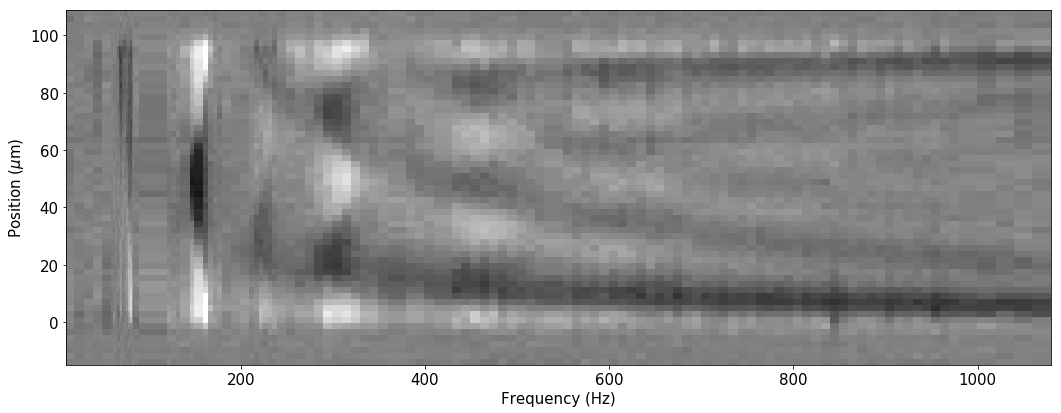

In [142]:
# Sonogram Plot 
use = 'Delta rho'
z_lim = np.array([-15, 110]) * 1e-6
movie = np.array([nz.trim(xlim=z_lim).y for nz in df_data[use]]).T
movie = (df_data.index.values, df_data[use].iloc[0].trim(xlim=z_lim).x * 1e6, movie / np.mean(df_data.amp))

clim = np.max(np.abs(movie[2])) * 0.75

fig, ax = plt.subplots(figsize = [15, 6])
# ax.get_yaxis().set_visible(0)
plt.pcolormesh(*movie, cmap='gray', vmin=-clim, vmax=clim)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Position ($\mu$m)')
# plt.colorbar()
plt.tight_layout()

_ = pd.DataFrame(movie[2], index=movie[1], columns=movie[0])
_.to_clipboard(excel=True)

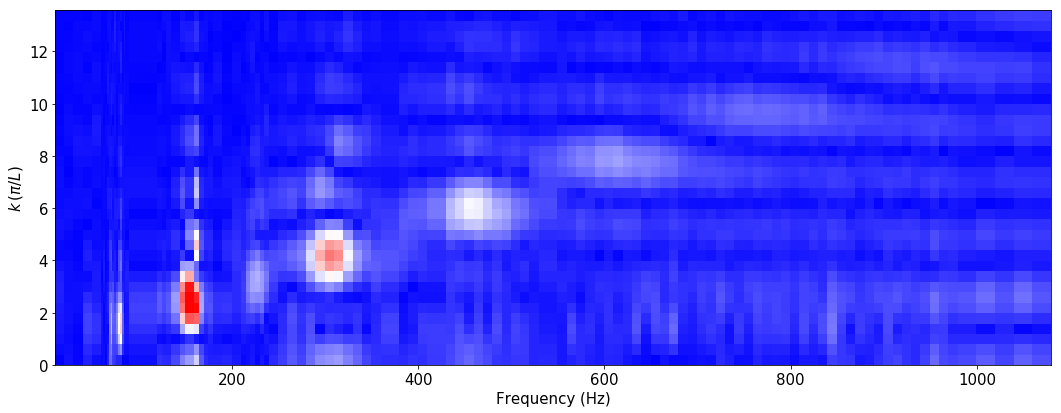

In [143]:
# Spatial Fourier Transform 
L = np.mean(df_data.length) * 1e6 * 1
k = np.arange(0, 7 * twopi/L, 0.2 * twopi / L)
k_scale = np.pi/L

movie_ft = np.array([np.abs(fourier_transform(tp.Curve(movie[1], movie[2][:, i].flatten()), k)) for i in range(len(movie[0]))]).T
movie_ft = [movie[0], k/k_scale, movie_ft]

clim = np.max(np.abs(movie_ft[2])) * 0.9

fig, ax = plt.subplots(figsize = [15, 6])
plt.pcolormesh(*movie_ft, cmap='bwr', vmax=clim)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$k \: \left(\pi / L \right)$')
plt.tight_layout()

_ = pd.DataFrame(movie_ft[2], index=movie_ft[1], columns=movie_ft[0])
_.to_clipboard(excel=True)

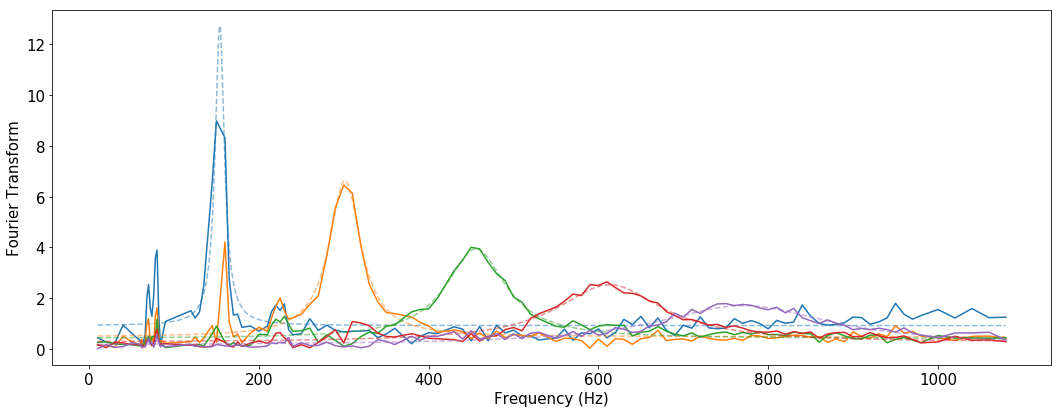

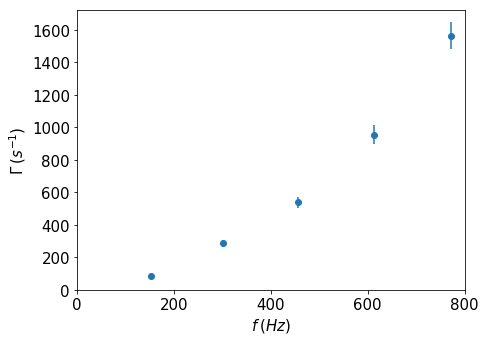

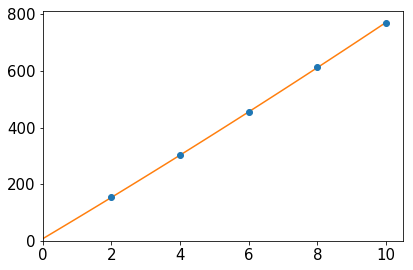

In [113]:
# Extracting widths from FT cuts 
modes = [5, 10, 14, 19, 24]
mode_num = np.array([2, 4, 6, 8, 10])

freq = 180/2 * mode_num
fr, fe = [], []

fig, ax = plt.subplots(figsize = [15, 6])
for i, m in enumerate(modes):
    c = tp.Curve(movie_ft[0], movie_ft[2][m, :])
    fr_, fe_ = c.fit(lorentzian_fitfun, [freq[i], 10, c.maxy, c.maxy/1000,], plot=False)
    fr.append(fr_)
    fe.append(fe_)
    plt.plot(*c.data, 'C{}'.format(i))
    plt.plot(*c.xyfitplot, 'C{}--'.format(i), alpha=0.5)
fr = np.array(fr)
fe = np.array(fe)
fr[:,1] = np.abs(fr[:,1])
fr[:,1] = fr[:,1] * twopi
fe[:,1] = fe[:,1] * twopi
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Fourier Transform')
plt.tight_layout()


freq = fr[:, 0]

# Fit poly2
c_gamma = tp.Curve(freq, fr[:, 1])
def poly2(x, a2, a1=0, a0=0):
    return a0 + a1 * x + a2 * x**2
fr_, fe_ = c_gamma.fit(poly2, [1,], plot=False, )
plt.show()

# Plot
plt.figure(figsize=[7, 5])
plt.errorbar(freq, fr[:, 1], fe[:, 1], fmt='o')
# plt.plot(np.linspace(0, freq[-1], 100), poly2(np.linspace(0, freq[-1], 100), *fr_))

# Fit poly1
def poly1(x, a1=0, a0=0):
    return a0 + a1 * x
fr_, fe_ = c_gamma.fit(poly1, [1,0], plot=False, xlim=[0, 500])
# plt.plot(np.linspace(0, freq[-1], 100), poly1(np.linspace(0, freq[-1], 100), *fr_))
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$f \: (Hz)$')
plt.ylabel(r'$\Gamma \: (s^{-1})$')
plt.tight_layout()

# Print 
_ = pd.DataFrame(dict(freq=freq, gammaHz=fr[:, 1], gammaHz_err=fe[:, 1]))
_.to_clipboard(excel=True)
res_freq_ft_fit = _['freq'].values
# print(_)

# Plot
polyfit = np.poly1d(np.polyfit(mode_num, fr[:, 0], 2))
plt.figure()
plt.errorbar(mode_num, fr[:, 0], fe[:, 0], fmt='o')
plt.plot(np.linspace(0, mode_num[-1], 100), polyfit(np.linspace(0, mode_num[-1], 100)))
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()

* kinematic viscosity $\eta$ for a unitary Fermi gas using dimentional analysis. Here $n$ is atomic number density 
$$ \eta = \hbar n \: f\left( \frac{T}{T_F} \right) $$

* More useful form using $\rho = m \: n$ the atomic mass density
$$ \frac{\eta}{\rho} = \frac{\hbar}{m}  \: f\left( \frac{T}{T_F} \right) $$

* Sound propagation differential equation
$$ find it and source it $$

* Relating decay of sound modes with viscosity, here $k = 2\pi / \lambda$ is the wave vector 
$$ \Gamma = \frac{4}{3} \frac{\eta}{\rho} k^2 = \frac{4}{3} \frac{\hbar}{m} k^2  \: f\left( \frac{T}{T_F} \right)   $$

* Interesting bit is the $f\left( \frac{T}{T_F} \right)$, the $\frac{\eta}{\rho}$ in units of $\frac{\hbar}{m}$
$$ \frac{\eta}{\rho} \left[\frac{\hbar}{m} \right] =  f\left( \frac{T}{T_F} \right) =  \frac{3}{4} \frac{m }{\hbar} \frac{\Gamma}{k^2} $$

* For standing waves, $\lambda_n = 2 L / n$. So, $k_n =  n\pi / L $. Here n represents the $n^{th}$ mode and not atomic density
$$ f\left( \frac{T}{T_F} \right) =  \frac{3}{4} \frac{m }{\hbar} \frac{\Gamma \: L^2}{n^2 \pi^2} $$

## 2D Profiles 

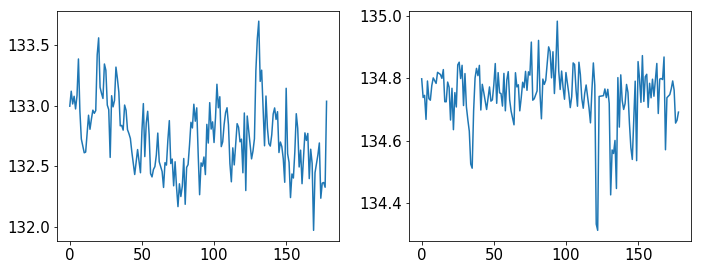

In [144]:
# Find the origin for each 2D app 
def get_origin_pixel(r):
    # Get the index of the right edge of the box == this is the y origin 
    use_center = (r.fitres_erf[0] + r.fitres_erf[1])/2
    y = tp.Curve((r.nz_raw.x - use_center) * 1e6, np.arange(len(r.nz_raw.x)))(0)
    # Get the center from xsec at that y pixel 
    x = tp.Curve(np.arange(len(r.image.xsec.center)), r.image.xsec.center)(y)
    return [x, y]

origin = np.array([get_origin_pixel(r) for i,r in df.iterrows()])
df['origin_x'], df['origin_y'] = origin[:,0], origin[:,1]

plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.plot(df.origin_x)
plt.subplot(122)
plt.plot(df.origin_y)
plt.tight_layout()

In [145]:
# Calculate all app for the same grid 

# define grid based on average origin 
r = df.iloc[0]
x = np.arange(r.image.app.shape[1]) - np.mean(df.origin_x)
y = np.arange(r.image.app.shape[0]) - np.mean(df.origin_y)
xx, yy = np.meshgrid(x, y)

# Function to compute app_shifted 
import scipy.interpolate
def compute_app_shifted(r):
    x_ = np.arange(r.image.app.shape[1]) - r.origin_x
    y_ = np.arange(r.image.app.shape[0]) - r.origin_y
    interp = scipy.interpolate.interp2d(x_, y_, r.image.app, kind='linear')
    return interp(x, y)

df['app_shifted'] = [compute_app_shifted(r) for i,r in df.iterrows()]

In [146]:
# x - variables 
print(df_data.index.values)
print(res_freq_ft_fit)

[   10.    20.    30.    40.    50.    60.    62.    64.    66.    68.
    70.    72.    74.    76.    78.    80.    82.    84.    85.    90.
   120.   125.   130.   135.   145.   150.   160.   165.   170.   175.
   180.   190.   200.   210.   215.   220.   225.   230.   235.   240.
   250.   260.   270.   280.   290.   300.   310.   320.   330.   340.
   350.   360.   380.   390.   400.   410.   430.   440.   450.   460.
   470.   480.   490.   500.   510.   520.   530.   550.   560.   570.
   580.   590.   600.   610.   620.   630.   640.   650.   660.   670.
   680.   690.   700.   710.   720.   730.   740.   750.   760.   770.
   780.   790.   800.   810.   820.   830.   840.   850.   860.   870.
   880.   890.   900.   910.   920.   930.   940.   950.   960.   970.
   980.  1000.  1020.  1040.  1060.  1080.]
[ 153.92593491  301.37755461  455.53352143  613.41794795  771.01383802]


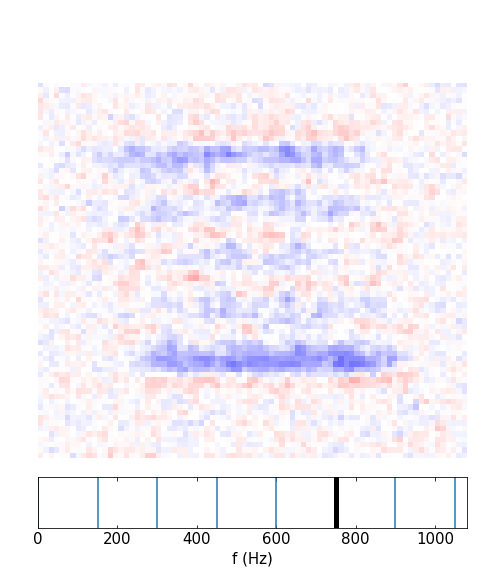

In [147]:
# Insitu Density 
import scipy.ndimage
freq = 750
freqs_plot = 150 * np.arange(10)
width = 80
height = 70
center = [0,0]

roi = get_roi(df.app_shifted.iloc[0], width=width, height=height, center=center)
bg_mean = np.mean([a/np.mean(a) for a in df[ df[bg_variable] == bg_value ].app_shifted], axis = 0)[roi]
data_mean = np.mean([a/np.mean(a) for a in df[ (df[bg_variable] != bg_value) & (df.x == freq) ].app_shifted], axis=0)[roi]

data_plot = data_mean - bg_mean
data_plot = scipy.ndimage.filters.gaussian_filter(data_plot, sigma=0.5, order=0,)
clim = np.max(np.abs(data_plot)) 
clim = 8
clim = [-clim, clim]

fig, ax = plt.subplots(figsize=[7, 8])
plt.tight_layout()
ax1, ax2 = divide_axes(ax, divider=0.1, shared=False)
ax.set_axis_off()
ax1.set_axis_off()
ax2.get_yaxis().set_visible(False)
ax.imshow(data_plot, origin=0, cmap='bwr', clim=clim)
ax2.set_xlim([0, np.max(df_data.index.values)])
for f in freqs_plot:
    ax2.axvline(f)
(ax2.axvline(freq, c='k', linewidth=5))
ax2.set_xlabel('f (Hz)')

In [148]:
freq_scanner = list(df_data.index.values)
freq_scanner = freq_scanner + [150]*6
freq_scanner = freq_scanner + [300]*6
freq_scanner = freq_scanner + [450]*6
freq_scanner = freq_scanner + [600]*6
freq_scanner = freq_scanner + [750]*6
freq_scanner = freq_scanner + [900]*6
freq_scanner = np.sort(freq_scanner)
freq_scanner

array([   10.,    20.,    30.,    40.,    50.,    60.,    62.,    64.,
          66.,    68.,    70.,    72.,    74.,    76.,    78.,    80.,
          82.,    84.,    85.,    90.,   120.,   125.,   130.,   135.,
         145.,   150.,   150.,   150.,   150.,   150.,   150.,   150.,
         160.,   165.,   170.,   175.,   180.,   190.,   200.,   210.,
         215.,   220.,   225.,   230.,   235.,   240.,   250.,   260.,
         270.,   280.,   290.,   300.,   300.,   300.,   300.,   300.,
         300.,   300.,   310.,   320.,   330.,   340.,   350.,   360.,
         380.,   390.,   400.,   410.,   430.,   440.,   450.,   450.,
         450.,   450.,   450.,   450.,   450.,   460.,   470.,   480.,
         490.,   500.,   510.,   520.,   530.,   550.,   560.,   570.,
         580.,   590.,   600.,   600.,   600.,   600.,   600.,   600.,
         600.,   610.,   620.,   630.,   640.,   650.,   660.,   670.,
         680.,   690.,   700.,   710.,   720.,   730.,   740.,   750.,
      

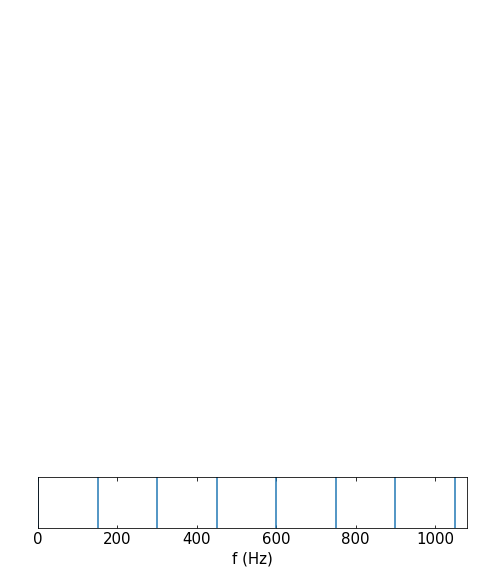

In [149]:
# Animation 

# Create list of artists for animation 
fig, ax = plt.subplots(figsize=[7, 8])
plt.tight_layout()
ax1, ax2 = divide_axes(ax, divider=0.1, shared=False)
ax.set_axis_off()
ax1.set_axis_off()
ax2.get_yaxis().set_visible(False)
ax2.set_xlabel('f (Hz)')
ax2.set_xlim([0, np.max(df_data.index.values)])
for f in freqs_plot:
    ax2.axvline(f)
artists = []

for x in freq_scanner:
    # Generate Data 
    roi = get_roi(df.app_shifted.iloc[0], width=width, height=height, center=center)
    bg_mean = np.mean([a/np.mean(a) for a in df[ df[bg_variable] == bg_value ].app_shifted], axis = 0)[roi]
    data_mean = np.mean([a/np.mean(a) for a in df[ (df[bg_variable] != bg_value) & (df.x == x) ].app_shifted], axis=0)[roi]
    data_plot = data_mean - bg_mean
    data_plot = scipy.ndimage.filters.gaussian_filter(data_plot, sigma=0.5, order=0,)
    
    # Make plot 
    p1 = ax.imshow(data_plot, origin=0, cmap='bwr', clim=clim)
    p2 = ax2.axvline(x, c='k', linewidth=5)
    artists.append([p1,p2])

ani = animation.ArtistAnimation(fig, artists, interval=200, repeat_delay=2000, repeat=True, )
ani.save('SonogramMovie-07-11-DS1.gif',  writer='imagemagick')
# HTML(ani.to_html5_video()) 

In [150]:
df_data.length.iloc[0] * 1e6

95.015731067858567